# Deep analysis of Wikipedia clickstream data

Wikipedia, a non-profit database for people to explore knowledge, has been widely used as a go-to reference website.To give you a sense of the scale of the data, the March 2016 release for English Wikipedia contained 25 million distinct “(referer, resource)” pairs from a total of 6.8 billion requests. This project is trying to answer questions that might be of business interests based on wikipedia clickstream data, and will also be a good reference for business analysis.

## 1. Data Source

All the clickstream data are public available and could be downloaded from
https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream

The Wikipedia Clickstream dataset contains counts of (referer, resource) pairs extracted from the request logs of Wikipedia. A referer is an HTTP header field that identifies the address of the webpage that linked to the resource being requested. The data shows how people get to a Wikipedia article and what links they click on. In other words, it gives a weighted network of articles, where each edge weight corresponds to how often people navigate from one page to another. To give an example, consider the figure below, which shows incoming and outgoing traffic to the "London" article on English Wikipedia during January 2015.

Herein, I adopted most recent 8 months data from Nov 2017 to Jun 2018 for this project. The goal of this project is:

1. Build a topic recommendation system for a given topic

2. Topic classification based on web traffic data

3. Advertisement profits prediction based on web traffic data and NLP analysis (classification and regression)

![Traffic of London](https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/London_clickstream.png/440px-London_clickstream.png)

## 2. Data Wrangling

In [1]:
# Import necessary packages to deal with plotting, dataframe and network analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import random


%matplotlib inline

# Import beautifulsoup package, urllib and regex
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re

In [2]:
# Load df
with open('pickle/2017_11/df.pickle','rb') as f:
    df = pickle.load(f)

#### The dataframe includes four columns: prev, curr, type and n. There are total 26 million records, with only 47 NA values. 

#### Prev
Sources leading to wiki topics/pages. In addition to wiki topics, other sources include 1. other-empty: direct enter through http; 2. other-search: link through search engine; 3. other external: link through other website; 4. other-internal: through non english wikipedia database; 5. other-other: Unknown source. NA means the sources have been removed or updated to a new one

#### Curr
Visited Wiki pages/topics. NA means the topics being updated or removed

#### Type
Three classes including external, other and link. External means sources are from external, other means both the source and curr are wiki topics, but there is no direct link between them. Link means both source and curr are wiki topics and there is direct link between them.

#### n
Number of clicks

In [3]:
df.head()

,prev,curr,type,n
0,other-empty,Holly_Hull,external,43
1,other-search,Holly_Hull,external,18
2,other-empty,Boy_Slaves,external,57
3,Peon,Boy_Slaves,link,12
4,List_of_films_featuring_slavery,Boy_Slaves,link,27


In [4]:
# Unique exteral sources
df.prev[df.prev.apply(lambda x: str(x).startswith('other'))].unique()

array(['other-empty', 'other-search', 'other-external', 'other-internal',
       'other-other'], dtype=object)

In [5]:
df.shape

(25982519, 4)

In [6]:
df.type.value_counts()

link        15649105
external     9560564
other         772850
Name: type, dtype: int64

In [7]:
df.isnull().sum()

prev    22
curr    25
type     0
n        0
dtype: int64

## 3. Exploratory Data Analysis

### 3.1 Global’s hot topics in Nov 2017

##### 3.1.1 The most viewed article in the month

People are interested in knowing about celebrities, and hot movies on Nov. The reason why Meghan_Markle climbs to the top is due to the engagement of Prince Harry and Meghan Markle on Nov 27, and the first episode of “Stranger Things” was watched by 15.8 million people within the first three days from Oct 27 and thus arouse people's interests throughout November. In addition, the distribution of the number of clicks is heavily right skewed, and almost 50% of articles are viewed less than 100 times, we will use this as the cut off

In [8]:
# Aggregate the clicks according to topics
article_link_in = df.groupby('curr').sum()

# Sort n of clicks by descending
article_link_in.sort_values(by='n', ascending=False).head(10)

,n
curr,
Main_Page,505262821
Hyphen-minus,39017884
XHamster,9537393
Meghan_Markle,8289694
Justice_League_(film),5480246
Stranger_Things,5231810
Charles_Manson,4553276
Thor:_Ragnarok,3725272
Deaths_in_2017,3299351


In [9]:
# Statistical distribution of article views.
# Notice the mean is 1530, while the median is 108. The data is heavily right skewed
article_link_in.describe()

,n
count,4.414255e+06
mean,1.536471e+03
std,2.415679e+05
min,1.000000e+01
25%,3.400000e+01
50%,1.080000e+02
75%,4.510000e+02
max,5.052628e+08


In [10]:
# Read article_link_in.pickle as a dictionary
with open('pickle/2017_11/article_link_in.pickle', 'rb') as f:
    article_link_in = pickle.load(f)

##### 3.1.2 The most cited sources in the month
The top referred sources are other sources insead of internal links, mainly from search engines and enter through http. For the internal links, the highest cited articles are hot movies such as stranger things, justice league and summary of events, such as deaths in 2017.

In [11]:
# The top refer sources are from search engine, empty string, external and internal. 
article_link_out = df.groupby('prev').sum()
article_link_out.sort_values(by='n', ascending=False).head(10)

,n
prev,
other-search,2978059866
other-empty,2291181777
other-external,132415436
other-internal,116059001
Main_Page,29716738
Stranger_Things,2815939
Justice_League_(film),2230895
Thor:_Ragnarok,1887976
Deaths_in_2017,1664140


In [12]:
# Read article_link_out.pickle as a dictionary
with open('pickle/2017_11/article_link_out.pickle', 'rb') as f:
    article_link_out = pickle.load(f)

### 3.2 Relations between hot topics
In order to analysis the relations, we need to establish the network. The purpose of the network analysis is to find the relations between different hot topics. To simiplify the problem, we built an undirected network (e.g., once two topics are linked and linked more than 100 times, they has relations), and we built edges based on direct linked articles. 

In [13]:
with open('pickle/2017_11/df_link.pickle','rb') as f:
    df_link = pickle.load(f)

In [14]:
# Load pickle file
import networkx as nx

with open('pickle/2017_11/clickstream.pickle','rb') as f:
    clickstream = pickle.load(f)

##### 3.2.1 Visualization of connections between different topics
There is a more intuitive visuallization of the network using nxviz. It showed that hot topics are closely related. For example, hot topics such as Deaths_in_2017 connected Lil_Peep, David_Cassidy and Charles_Manson. And with more and more nodes added in, more connections will be revealed.

In [15]:
df_article_link_in = df.groupby('curr').sum().sort_values(by='n', ascending=False)

# Define methods to show top num of hot topics
def hot_topics(num):
    return df_article_link_in.iloc[:num,:]

In [16]:
# Find relations between top 10 topics
from itertools import combinations, permutations, chain

for i,j in combinations(hot_topics(10).index,2):
    if clickstream.has_edge(i,j):
        print('{},{} has relations'.format(i,j))

Main_Page,Deaths_in_2017 has relations
Justice_League_(film),Thor:_Ragnarok has relations
Charles_Manson,Deaths_in_2017 has relations
Deaths_in_2017,Lil_Peep has relations


Top 10 hot topics

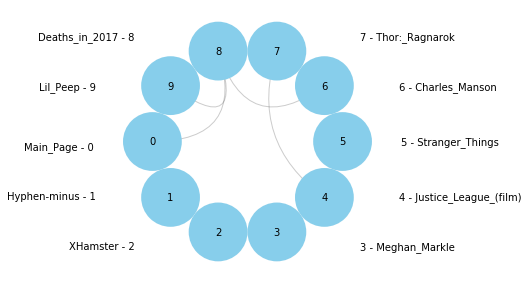

In [17]:
from nxviz import CircosPlot

def plot_circos(num):
    """Circos plot for top num of hot topics"""
    c = CircosPlot(clickstream.subgraph(hot_topics(num).index), node_labels = True, node_label_layout = 'numbers')
    c.node_colors = ["skyblue" for node_color in c.node_colors]
    # the rotated labels take up more space, so we will have to increase the
    # padding a bit. 15% on all sides works well here.
    plt.tight_layout(rect=(0.15, 0.15, 0.85, 0.85))
    c.draw()

plot_circos(10)

Top 20 hot topics

We see more connections are established. Megan markle is connected with Prince Harry and Matt Lauer. Stranger things are connected with Millie Bobby Brown.

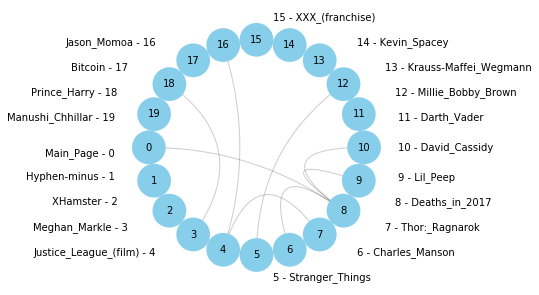

In [18]:
plot_circos(20)

#### How to find connection between topics that are not directly connected?

- Use network analysis, we can find the shortest path between Kevin Spacey and Meghan Markle. It seems like they both feature in Horrible Bosses, and their movies/showes are rated by IMDb

In [19]:
# Return the shorted path between Kevin Sparcey and Meghan Markle. 
# Cutoff 2 is chosen because the shortest path between these two topics is 2

list(nx.all_simple_paths(clickstream,'Kevin_Spacey','Meghan_Markle',cutoff = 2))

[['Kevin_Spacey', 'Horrible_Bosses', 'Meghan_Markle'],
 ['Kevin_Spacey', 'IMDb', 'Meghan_Markle']]

### 3.3 Topics with high degree centrality and betweeness centrality
$DegreeCentrality = \frac{Number of Neighbors}{Number of Possible Neighbors}$

$Betweenness Centrality =\frac{Number of Shortest Paths through Node}{Number of Possible Neighbors}$

##### 3.3.1 Top 10 topics in degree centrality
It seems like the topics that has the most connections are United States, which directly connects 1,897 nodes with 537,227 clicks and 283 clicks/link. 99% of articles has neigbhors less than 44. So United States node having 1897 connections are very significant large number.

However, if we want to know which articles are more influential, e.g. more clicks than other articles, we can tell stranger_things, which directly connects with 213 nodes, lead the board with 13,109 clicks per link and totally 2,792,254 clicks.

In [20]:
with open('pickle/2017_11/degree.pickle','rb') as f:
    degree = pickle.load(f)

# Select nodes with top 10 neighbors
sorted(degree.items(), key = lambda x: x[1])[::-1][:10]

[('United_States', 1897),
 ('World_War_II', 926),
 ('Deaths_in_2017', 797),
 ('English_language', 796),
 ('Linux', 697),
 ('Microsoft_Windows', 625),
 ('List_of_people_who_disappeared_mysteriously', 602),
 ('Wikipedia', 601),
 ('C++', 584),
 ('Operating_system', 574)]

In [21]:
degree_value = np.array(list(degree.values()))

np.percentile(degree_value,[10,99])

array([  1.,  44.])

In [22]:
with open('pickle/2017_11/influence_link.pickle','rb') as f:
    influence_link = pickle.load(f)

with open('pickle/2017_11/influence_other.pickle','rb') as f:
    influence_other = pickle.load(f)

In [23]:
# Number of clicks for 'United States' and 'Stranger things'
print('United States has {} neigbhors, with total {} numbers of clicks.'.format(degree.get('United_States'), 
                                                                                influence_link.get('United_States')))
print('Stranger Things has {} neighbors, with total {} numbers of clicks.'.format(degree.get('Stranger_Things'), 
                                                                                 influence_link.get('Stranger_Things')))

United States has 1897 neigbhors, with total 537227 numbers of clicks.
Stranger Things has 213 neighbors, with total 2792254 numbers of clicks.


##### 3.3.2 Top 10 Topics in betweenness centrality
The topic with highest betweenness centrality is 'United States'

In [24]:
with open('pickle/2017_11/betweenness.pickle', 'rb') as f:
    betweenness = pickle.load(f)

In [25]:
sorted(betweenness.items(), key = lambda x: x[1], reverse=True)[:10]

[('United_States', 0.14563736750407139),
 ('2017_in_film', 0.07023631312825669),
 ('United_Kingdom', 0.02631950996951287),
 ('India', 0.02599113035072937),
 ('Donald_Trump', 0.022153736214173967),
 ('List_of_highest-grossing_films', 0.02095359260921725),
 ('Deaths_in_2017', 0.020948183097671803),
 ('World_War_II', 0.018945905822983604),
 ('List_of_best-selling_music_artists', 0.017011972668295818),
 ('Netflix', 0.01695179517020445)]

### 3.4 Topics that has most similar topics
It is interesting to notice that the top tiers are countries and the second tiers are football teams.

In [26]:
with open('pickle/2017_11/size_maximal_clique.pickle','rb') as f:
    size_maximal_clique = pickle.load(f)

In [27]:
sorted(size_maximal_clique.items(), key = lambda x:x[1], reverse=True)[:20]

[('Russia', 15),
 ('United_States', 15),
 ('Germany', 15),
 ('United_Kingdom', 15),
 ('Japan', 15),
 ('Australia', 15),
 ('China', 15),
 ('France', 15),
 ('India', 15),
 ('List_of_countries_by_GDP_(nominal)_per_capita', 15),
 ('Canada', 15),
 ('List_of_countries_by_GDP_(nominal)', 15),
 ('List_of_countries_by_GDP_(PPP)_per_capita', 15),
 ('Gross_domestic_product', 15),
 ('List_of_countries_by_GDP_(PPP)', 15),
 ('Purchasing_power_parity', 15),
 ('Italy_national_football_team', 14),
 ('2006_FIFA_World_Cup', 14),
 ('Argentina_national_football_team', 14),
 ('Brazil_national_football_team', 14)]

### 3.5 Topics Recommendation based on user’s specific interests
Maximum clique of specific topic will reveal other topics that are closely related with this topic, and thus could be used for recommendation systems. We will answer questions such as: are there any other topics that might also interest you? The recommendation results will show links with highest clicks

In [28]:
def number_of_clicks(df_link, neighbor_list, topic):
    """Calculate the number of clicks between certain topic and topics in cluster"""
    
    count = 0

    df_link_topic = df_link[np.logical_or(df_link.prev==topic,df_link.curr==topic)]
    
    # Build a dictionary storing key as related topics and values as number of links
    h = {}
    for i in neighbor_list:
        # Count two conditions, either i in prev, topic in curr or topic in prev, i in curr
        count += df_link_topic[(df_link_topic.prev==i) & (df_link_topic.curr==topic)].n.sum()
        count += df_link_topic[(df_link_topic.prev==topic) & (df_link_topic.curr==i)].n.sum()
        h[i] = count
        
        count = 0
        
    return h

In [29]:
def topic_recommendation(topic_list, top_num=3):
    """Select clusters that have the top 3 (by default) most total clicks"""
    for topic in topic_list:
        if not np.logical_or(topic in df_link.prev.values, topic in df_link.curr.values):
            return '{} not in the database'.format(topic)
    
    else:
        neighbor_list = []
        set_intersection = set(clickstream.neighbors(topic_list[0]))
        
        for topic in topic_list:
            neighbor_list.extend(clickstream.neighbors(topic))
            set_new = set(clickstream.neighbors(topic))
            set_intersection = set_intersection.intersection(set_new)
        
        if set_intersection:
            return [i for (i,j) in sorted(number_of_clicks(df_link, set_intersection, topic).items(), key = lambda x: x[1],reverse=True)[:top_num]]
        else:
            return [i for (i,j) in sorted(number_of_clicks(df_link, neighbor_list, topic).items(), key = lambda x: x[1],reverse=True)[:top_num]]
        

In [30]:
def topic_image(topic):
    from IPython.display import Image
    from IPython.core.display import HTML 

    try:
        file = urlopen('https://en.wikipedia.org/wiki/'+topic)
        soup = BeautifulSoup(file,'html.parser')
        file.close()
        url_link = 'https:' + soup.find('tbody').find('img')['src']
        return Image(url= url_link)
    except:
        pass

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
with open('clickstream_transform_tfidf.pickle', 'rb') as f:
    clickstream_transform_tfidf = pickle.load(f)

with open('tfidf_vector_clickstream.pickle', 'rb') as f:
    tfidf_vector_clickstream = pickle.load(f)

In [33]:
from sklearn.metrics import pairwise
from fuzzywuzzy import fuzz, process

def search_item(topic):
    
    l = np.where(pairwise.cosine_similarity(clickstream_transform_tfidf, tfidf_vector_clickstream.transform([topic]))[:,0]>0.5)
    
    match = []
    for i in l[0]:
        match.append(clickstream.nodes()[i])
    
    # Get a list of matches ordered by score, default limit to 5
    results = process.extract('_'.join(topic.split()), match,limit=3)
    try:
        if results[0][1] == 100:
            return results[0][0]
        else:
            return [i for i,j in results]
    except:
        pass

C:\Users\Liu\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [34]:
topic_image(search_item('Donald trump'))

In [35]:
# Show recommendations of topics related with 'United States' and 'Donald_Trump'
l = []
for i in topic_recommendation(['United_States','Donald_Trump']):
    l.append(i)
l

['Barack_Obama', 'President_of_the_United_States', 'Mike_Pence']

### 3.6 Download and preprocess data for other months 

We summarized all the procedures needed to process Nov 2017 clickstream data files. Once we have df downloaded, we can process our data, store dataframe and network data as pickle files, and return dataframe ready for analysis.

- Define methods to calculate click through rate(ctr) of topic

In [36]:
def ctr(topic):
    
    if not topic in article_link_in:
        return 0
    if not topic in influence_link:
        return 0
    
    return influence_link.get(topic)/article_link_in.get(topic)
    

- Generate web traffic features for topic list

In [37]:
from collections import defaultdict

def feature_generation(topic_list):
    
    feature_dict = defaultdict(list)
    
    for i in set(topic_list):
        
        feature_dict[i].extend([degree.get(i,0),
                                influence_link.get(i,0),
                                influence_other.get(i,0),
                                betweenness.get(i,0),
                                ctr(i),
                                size_maximal_clique.get(i,0),
                                article_link_in.get(i,0),
                                article_link_out.get(i,0)])
    return feature_dict

- Define pipeline methods that download and preprocess data

In [38]:

def file_processing(df, name_list, movie_list, folder):
    # df and df_link
    df_link = df[df.type=='link']
    df_link = df_link[df_link.n>100]
    df_link = df_link.dropna()
    
    with open('pickle/' + folder + '/df_link.pickle','wb') as f:
        pickle.dump(df_link, f)

    # Network
    clickstream = nx.Graph()

    clickstream.add_nodes_from(df_link.prev)
    clickstream.add_nodes_from(df_link.curr)

    clickstream.add_edges_from(zip(df_link.prev, df_link.curr))
    with open('pickle/' + folder +'/clickstream.pickle','wb') as f:
        pickle.dump(clickstream, f)

    # Degree
    degree = nx.degree(clickstream)
    with open('pickle/' + folder +'/degree.pickle','wb') as f:
        pickle.dump(degree, f)
        
    # Betweenness Centrality. Take Top 5000 most influencial topics
    clickstream_subgroup = clickstream.subgraph(df_link.groupby(by = 'prev').n.sum().sort_values(ascending=False)[:5000].index)
    betweenness = nx.betweenness_centrality(clickstream_subgroup)
    with open('pickle/' + folder + '/betweenness.pickle','wb') as f:
        pickle.dump(betweenness, f)

    # size_maximal_clique
    size_maximal_clique = {}
    for i in set(movie_list + name_list):
        try:
            size_maximal_clique[i] = nx.node_clique_number(clickstream, i)
        except:
            size_maximal_clique[i] = 0
    
    with open('pickle/' + folder + '/size_maximal_clique.pickle','wb') as f:
        pickle.dump(size_maximal_clique, f)
        
    # Influence link
    influence_link = dict(df_link.groupby(by = 'prev').n.sum())
    with open('pickle/' + folder + '/influence_link.pickle','wb') as f:
        pickle.dump(influence_link, f)
        
    # Influence other
    influence_other = dict(df[df.type=='other'].groupby(by = 'prev').n.sum())
    with open('pickle/' + folder + '/influence_other.pickle','wb') as f:
        pickle.dump(influence_other, f)
        
    # Article link in
    article_link_in = df.groupby('curr').sum()
    article_link_in = dict(zip(article_link_in.index, article_link_in.n.values))
    with open('pickle/' + folder + '/article_link_in.pickle','wb') as f:
        pickle.dump(article_link_in, f)

    # Article link out
    article_link_out = df.groupby('prev').sum()
    article_link_out = dict(zip(article_link_out.index, article_link_out.n.values))
    with open('pickle/' + folder + '/article_link_out.pickle','wb') as f:
        pickle.dump(article_link_out, f)
        
    # Generate dataframe

    random.seed(1)
    random_movie_list = np.random.choice(movie_list, 6000, replace = False)

    df_new = pd.DataFrame(feature_generation(name_list)).T

    df_new = df_new.append(pd.DataFrame(feature_generation(random_movie_list)).T)

    df_new.columns = ['n_neighbors','clicks_link','clicks_other','betweenness','ctr','size_maximal_clique','n_views','n_referred']

    df_new['label'] = np.repeat([0,1],[len(set(name_list)),len(set(random_movie_list))])
    
    with open('pickle/' + folder + '/df_new.pickle','wb') as f:
        pickle.dump(df_new, f)
    
    return df_new

- Process other Months' data

## 4. Predict the topic class
Based on website traffic data, such as degree of centrality, betweenness centrality, number of clicks leading to other topics,  click through rate(ctr), and times of viewed and referred, we can predict the class of the article (whether it is movie stars or movie names). Movies were collected from 1990 to 2019. All the data were scraped from wiki.

### 4.1 Python code for scraping movie stars and movie names from wiki

Read stored pickle files of movie star list and movie list

In [39]:
# Load movie list and name list

with open('pickle/name_list.pickle','rb') as f:
    name_list = pickle.load(f)
    
with open('pickle/movie_list.pickle','rb') as f:
    movie_list = pickle.load(f)
    
total_list = name_list + movie_list

### 4.2 Data Preparation for modeling

- Initiate dataframe df_new for 2017-11 data

In [40]:
with open('pickle/2017_11/df_new.pickle','rb') as f:
    df_new = pickle.load(f)

In [41]:
df_new.head()

,n_neighbors,clicks_link,clicks_other,betweenness,ctr,size_maximal_clique,n_views,n_referred,label
A,3.0,0.0,0.0,0.0,0.000000,3.0,195278.0,0.0,0
AJ_Michalka,26.0,15278.0,42.0,0.0,0.351404,4.0,43477.0,16088.0,0
Aaliyah_Haughton,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
Aaron_Carter,19.0,12290.0,167.0,0.0,0.173502,4.0,70835.0,14365.0,0
Aaron_Eckhart,47.0,12931.0,41.0,0.0,0.233294,4.0,55428.0,14219.0,0


- Append other months' data

In [42]:
for folder in ['2017_12','2018_01','2018_02','2018_03','2018_04','2018_05','2018_06']:
    with open('pickle/'+folder+'/df_new.pickle', 'rb') as f:
        temp = pickle.load(f)
    df_new = df_new.append(temp)    

- Scale the data

In [43]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
xdata = scale.fit_transform(df_new.drop('label', axis = 1))
ydata = df_new['label']


In [44]:
xdata.shape

(81551, 8)

- Split data into training and testing sets

In [45]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size = 0.3, random_state = 1)

In [46]:
# Define method for model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score

def model_performance(ytest, ypredict):
    print('Accuracy:      {}'.format(accuracy_score(ytest, ypredict)))
    print('Roc_Auc_Score: {}'.format(roc_auc_score(ytest, ypredict)))
    print('F1_Score:      {}'.format(f1_score(ytest, ypredict)))
    print('Confusion Matrix:\n{}'.format(confusion_matrix(ytest, ypredict)))

### 4.3 Modeling for classification

#### Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression

In [48]:
with open('pickle/lr.pickle','rb') as f:
    lr = pickle.load(f)

lr_predict = lr.predict(xtest)

model_performance(ytest, lr_predict)

Accuracy:      0.7142565192512057
Roc_Auc_Score: 0.7243622894355001
F1_Score:      0.7205947004516208
Confusion Matrix:
[[8460 5039]
 [1952 9015]]


#### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [50]:
with open('pickle/rf.pickle','rb') as f:
    rf = pickle.load(f)

model_performance(ytest, rf.predict(xtest))

Accuracy:      0.8679800539524237
Roc_Auc_Score: 0.8747944565737972
F1_Score:      0.8646383371050206
Confusion Matrix:
[[10920  2579]
 [  651 10316]]


In [51]:
# Feature importance

In [52]:
rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### KNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [54]:
with open('pickle/knn.pickle','rb') as f:
    knn = pickle.load(f)

model_performance(ytest, knn.predict(xtest))

Accuracy:      0.8552685359274095
Roc_Auc_Score: 0.8630527447625829
F1_Score:      0.8531984577753824
Confusion Matrix:
[[10635  2864]
 [  677 10290]]


### 4.4 Interpretation of features and their importance in prediction
Herein, we summarized the feature importance obtained from random forest along with coefficients obtained from logistic regression, and we ranked the importance from high to low. It is interesting that the top 4 features explained 76% variance. 
Notice Actor/Actress names are labeled as 0, movie names are labeled as 1. Actor/Actress names rendered more views than movies (negative coefficient for n_views), while movie topics tended to be related with more other articles and thus have higher ctr rates (positive coefficient for ctr and n_referred). 

In [55]:
feature_eval = pd.DataFrame.from_dict({'Feature':df_new.columns[:-1],
                                       'Importance': rf.feature_importances_, 
                                       'Coefficient':lr.coef_[0]})

feature_eval = feature_eval.set_index('Feature')

feature_eval.sort_values('Importance', ascending = False)

,Coefficient,Importance
Feature,,
n_views,-2.843770,0.349021
ctr,1.636485,0.191675
n_referred,3.058649,0.180420
n_neighbors,0.076477,0.101809
clicks_link,-2.217717,0.080912
clicks_other,0.413321,0.061375
size_maximal_clique,-1.403904,0.029850
betweenness,0.201414,0.004938


## 5. Predict profits from advertisement clicks
Herein, we made a bold assumption that Wiki is for profit and would like to predict how much Wiki will earn from clicks of the advertisement. 

Suppose we would like to launch an advertisement campaign for the movie 'Stranger Things'. 

Our goals are: 1) Identify topics that we should post the ad on in order to earn the highest profits; 2) Predict profits earned from ad clicking. 

The expected revenue coming from ad clicks can be calculated as ctr\*(profit/click)\*clicks. So if profit per click is \$2, ctr is 0.04 and clicks are 1,000, our anticipated profit would be \$80

### 5.1 Identify topics earning highest profits

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [57]:
# Define methods for calculating profits from different articles

def ad_profit(df_link, article_link_in, ad, price_per_click=2):

    # Select ad view and assign to df_ad
    df_ad = df_link[df_link.curr == ad]

    # Create ctr column, calculate the ctr rate of webpage containing this ad
    df_ad['n_neighbors'] = df_ad.apply(lambda x: degree.get(x.prev, 0), axis = 1)
    df_ad['clicks_link'] = df_ad.apply(lambda x: influence_link.get(x.prev, 0), axis = 1)
    df_ad['clicks_other'] = df_ad.apply(lambda x: influence_other.get(x.prev, 0), axis = 1)
    df_ad['betweenness'] = df_ad.apply(lambda x: betweenness.get(x.prev, 0), axis = 1)
    df_ad['ctr'] = df_ad.apply(lambda x: ctr(x.prev), axis = 1)
    df_ad['size_maximal_clique'] = df_ad.apply(lambda x: size_maximal_clique.get(x.prev, 0), axis = 1)
    df_ad['n_views'] = df_ad.apply(lambda x: article_link_in.get(x.prev, 0), axis = 1)
    df_ad['n_referred'] = df_ad.apply(lambda x: article_link_out.get(x.prev, 0), axis = 1)
    df_ad['ctr'] = df_ad.apply(lambda x: x.n/article_link_in.get(x.prev,0), axis = 1)
    df_ad['profit'] = df_ad.apply(lambda x: x.n*x.ctr*price_per_click, axis = 1)
    
    df_ad = df_ad.sort_values('profit', ascending=False)
    df_ad.index = range(len(df_ad))
    
    return df_ad

In [58]:
def df_ad_data_prepare(topic):
    
    df_ad = pd.DataFrame()

    for folder in ['2017_11','2017_12','2018_01','2018_02','2018_03','2018_04','2018_05','2018_06']:

        with open('pickle/'+folder+'/df_link.pickle', 'rb') as f:
            df_link = pickle.load(f)
        with open('pickle/'+folder+'/article_link_in.pickle', 'rb') as f:
            article_link_in = pickle.load(f)
        with open('pickle/'+folder+'/degree.pickle', 'rb') as f:
            degree = pickle.load(f)
        with open('pickle/'+folder+'/influence_link.pickle', 'rb') as f:
            influence_link = pickle.load(f)
        with open('pickle/'+folder+'/influence_other.pickle', 'rb') as f:
            influence_other = pickle.load(f)
        with open('pickle/'+folder+'/betweenness.pickle', 'rb') as f:
            betweenness = pickle.load(f)
        with open('pickle/'+folder+'/size_maximal_clique.pickle', 'rb') as f:
            size_maximal_clique = pickle.load(f)
        with open('pickle/'+folder+'/article_link_out.pickle', 'rb') as f:
            article_link_out = pickle.load(f)

        df_ad = df_ad.append(ad_profit(df_link, article_link_in, topic))
                
    return df_ad

In [59]:
with open('df_ad.pickle','rb') as f:
    df_ad = pickle.load(f)

In [60]:
df_ad.shape

(480, 13)

It could be seen that 196 articles (total 480 articles) account for 95% of total profits. Our goal is thus to differentiate high profitable topics vs. other topics

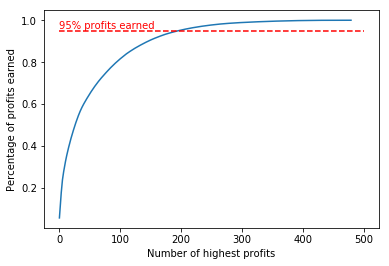

In [61]:
# 196 highest profits account for 95% profits
_ = plt.plot(range(len(df_ad)), np.cumsum(df_ad.sort_values('profit', ascending=False).profit/df_ad.profit.sum()))
plt.plot([0,500], [0.95, 0.95], 'r--')
plt.annotate('95% profits earned', xy = (0,0.96), xytext = (0,0.96),color = 'r')
plt.xlabel('Number of highest profits')
plt.ylabel('Percentage of profits earned')

Label the top 196 articles as 1, and the rest as 0

In [62]:
def ad_preprocess(df_ad):
    
    df_ad_new = df_ad
    df_ad_new.index = range(len(df_ad_new))
    
    # Select the first index where the cumulative percentage of profits earned higher than 95%
    index = np.sum(np.cumsum(df_ad_new.sort_values('profit', ascending=False).profit/df_ad_new.profit.sum())<0.95)
    
    # If article belongs to high profits, label decision 1, else label 0
    df_ad_new['decision'] = df_ad_new.profit.apply(lambda x: x>=df_ad_new.loc[index, 'profit']).astype(int)

    return df_ad_new

df_ad_new = ad_preprocess(df_ad)

In [63]:
df_ad_new.head()

,prev,curr,type,n,n_neighbors,clicks_link,clicks_other,betweenness,ctr,size_maximal_clique,n_views,n_referred,profit,decision
0,Millie_Bobby_Brown,Stranger_Things,link,42191,57,181137,5490,0.003485,0.017489,8,2412412,187437,1475.768220,1
1,Joe_Keery,Stranger_Things,link,23018,25,59360,1953,0.000711,0.022868,8,1006578,61619,1052.731778,1
2,Duffer_Brothers,Stranger_Things,link,17847,29,101286,891,0.000206,0.029125,4,612774,102659,1039.585260,1
3,Stranger_Things_(disambiguation),Stranger_Things,link,2163,4,3598,23,0.000000,0.229034,3,9444,3911,990.802414,1
4,Finn_Wolfhard,Stranger_Things,link,20771,34,86363,929,0.000909,0.020595,8,1008546,88387,855.557289,1


#### 5.1.1 Identify high profitable topics based on NLP

Our goal is try to identify the high profitable topics (topics contribute to 95% profits and labeled 1) based on NLP. Herein, we used Bag-of-Words and TFIDF to transform the text and predict whether these articles will earn high profits.

In [64]:
# Identify the high_profit_articles and low profit articles in last 8 months

high_profits_articles = list(set(df_ad_new.prev[df_ad_new.decision == 1].unique())- set(df_ad_new.prev[df_ad_new.decision == 0].unique()))

low_profits_articles = list(set(df_ad_new.prev[df_ad_new.decision == 0].unique())- set(df_ad_new.prev[df_ad_new.decision == 1].unique()))

In [65]:
from nltk.tokenize import regexp_tokenize

def extract_text(topic):
    try:
        file = urlopen('https://en.wikipedia.org/wiki/' + topic)
        soup = BeautifulSoup(file, 'html.parser')

        l = soup.find_all('p')
        result = ''

        for i in l:
            result += ''.join(regexp_tokenize(str(i), r'>([\w\s\!\"#$%&\'\()*\+,-./:;=\?@\\\^_`{|}~]+)<')).strip()

        return result
    except:
        pass

In [66]:
with open('dict_articles.pickle', 'rb') as f:
    dict_articles = pickle.load(f)

In [67]:
# Convert dict to dataframe
df_articles = pd.DataFrame(dict_articles)

In [68]:
df_articles.head()

,decision,text,topic
0,1,"Matthew Avery Modine (born March 22, 1959) is ...",Matthew_Modine
1,1,"Telltale Incorporated, doing business as Tellt...",Telltale_Games
2,1,"Daniel Rosenfeld, (born 9 May 1989) also known...",C418
3,1,"Sadie Sink (born April 16, 2002) is an America...",Sadie_Sink
4,1,Charlie Heaton is an English actor and musicia...,Charlie_Heaton


BOW and TFIDF based on sklearn package

In [69]:
# BOW and TFIDF packages from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_articles['text'], df_articles['decision'], test_size = 0.3, random_state = 10)

BOW transformation using 1 word

In [70]:
count_vector = CountVectorizer(stop_words='english')

# Fit and transform train data using BOW vectorizer
count_train = count_vector.fit_transform(xtrain)

# Transform test data using BOW vectorizer
count_test = count_vector.transform(xtest)

TFIDF transformation using 1 word

In [71]:
tfidf_vector = TfidfVectorizer(stop_words='english')

# Fit and transform train data using tfidf vectorizer
tfidf_train = tfidf_vector.fit_transform(xtrain)

# Transform test data using tfidf vectorizer
tfidf_test = tfidf_vector.transform(xtest)

#### 5.1.2 Modeling using naive_bayes, Random Forest and Logistic Regression

##### - Naive Bayes Model
Herein, we compared the model performance using Bag-of-Words and TFIDF data based on naive baysian model. They have the identical the same accuracy, ROC score and F1-score

In [72]:
from sklearn.naive_bayes import MultinomialNB

In [73]:
# BOW data
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, ytrain)

nb_pred = nb_classifier.predict(count_test)

model_performance(ytest, nb_pred)

Accuracy:      0.8214285714285714
Roc_Auc_Score: 0.8214285714285714
F1_Score:      0.8275862068965518
Confusion Matrix:
[[11  3]
 [ 2 12]]


In [74]:
# TFIDF data
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, ytrain)

nb_pred = nb_classifier.predict(tfidf_test)

model_performance(ytest, nb_pred)

Accuracy:      0.8214285714285714
Roc_Auc_Score: 0.8214285714285714
F1_Score:      0.8275862068965518
Confusion Matrix:
[[11  3]
 [ 2 12]]


##### - Random Forest Model

For model performance using BOW and TFIDF data, using BOW data performs better. Top 100 words represent the crucial difference between high-profitable topics and low-profitable topics

In [75]:
# BOW Data
rf = RandomForestClassifier(random_state=1)
rf.fit(count_train, ytrain)

rf_predict = rf.predict(count_test)

model_performance(ytest, rf_predict)

Accuracy:      0.75
Roc_Auc_Score: 0.75
F1_Score:      0.7586206896551724
Confusion Matrix:
[[10  4]
 [ 3 11]]


In [76]:
# TFIDF Data
rf = RandomForestClassifier(random_state=1)
rf.fit(tfidf_train, ytrain)

rf_predict = rf.predict(tfidf_test)

model_performance(ytest, rf_predict)

Accuracy:      0.6785714285714286
Roc_Auc_Score: 0.6785714285714285
F1_Score:      0.689655172413793
Confusion Matrix:
[[ 9  5]
 [ 4 10]]


Select the most important features using RF. It is indicated that top 100 words out of 10540 words (less than 1%) are sufficient to explain more than 95% variance of the data.

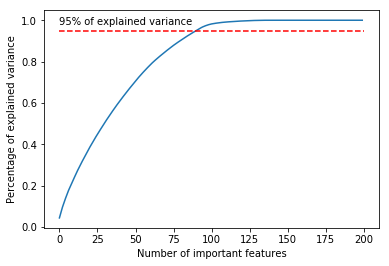

In [77]:
plt.plot(np.cumsum(sorted(rf.feature_importances_, reverse=True))[:200])
plt.plot([0,200],[0.95, 0.95], 'r--')
plt.annotate('95% of explained variance', xy = (0,0), xytext = (0,0.98))
plt.xlabel('Number of important features')
plt.ylabel('Percentage of explained variance')

In [78]:
# Select the top important features
top_important_feature = np.argsort(rf.feature_importances_)[::-1][:100]

In [79]:
# Show the top important features
features_rf = np.array(count_vector.get_feature_names())[top_important_feature]
features_rf

array(['used', 'numerous', 'characters', 'expressed', 'plans', 'history',
       'creative', 'situation', 'new', 'agent', 'individual', 'wanting',
       'serve', 'award', 'internet', 'weighted', 'august', 'announced',
       'key', 'metacritic', 'area', 'gave', 'super', 'arts', 'common',
       'advertising', 'containing', 'write', 'known', 'achievement',
       'contains', 'compared', 'sold', 'pst', 'compositions', 'scene',
       'waffle', 'broadway', 'september', 'eighth', 'hands', 'created',
       'hit', 'twenties', 'film', 'voted', 'times', 'beatles', 'took',
       'members', 'reality', '29', 'act', 'refer', 'jr', 'crossover',
       'existing', 'losing', 'able', '1998', 'sharp', '2011', 'alonesales',
       'fair', 'murder', 'positive', 'playing', 'second', 'homage',
       'review', 'est', '1995', 'travers', 'numbers', 'rama', 'movie',
       'arrived', 'ladder', 'club', 'abnormalities', 'following', '24',
       'played', 'covered', 'catch', 'university', 'dragon', 'york',
 

##### - Logistic Regression Model

For model performance using BOW and TFIDF data, using BOW data performs better. Using most important 100 words achieves similar performance with full words.

In [80]:
# Prediction using top 100 words

lr = LogisticRegression()
lr.fit(count_train[:, top_important_feature], ytrain)

lr_predict = lr.predict(count_test[:,top_important_feature])

model_performance(ytest, lr_predict)

Accuracy:      0.8214285714285714
Roc_Auc_Score: 0.8214285714285714
F1_Score:      0.8148148148148148
Confusion Matrix:
[[12  2]
 [ 3 11]]


In [81]:
# Prediction using full words

lr = LogisticRegression()
lr.fit(count_train, ytrain)

with open('lr_profitable_article.pickle', 'wb') as f:
    pickle.dump(lr, f)
    
lr_predict = lr.predict(count_test)

model_performance(ytest, lr_predict)

Accuracy:      0.8571428571428571
Roc_Auc_Score: 0.8571428571428572
F1_Score:      0.8666666666666666
Confusion Matrix:
[[11  3]
 [ 1 13]]


In [82]:
# Use Lasso to select importance features

lr_lasso = LogisticRegression(penalty='l1', random_state=1)
lr_lasso.fit(count_train, ytrain)
    
lr_lasso_predict = lr_lasso.predict(count_test)

model_performance(ytest, lr_lasso_predict)

Accuracy:      0.8214285714285714
Roc_Auc_Score: 0.8214285714285714
F1_Score:      0.8148148148148148
Confusion Matrix:
[[12  2]
 [ 3 11]]


In [83]:
# Totally 32 non-zero features were selected by Lasso
features_lasso = np.array(count_vector.get_feature_names())[np.where(lr_lasso.coef_ != 0)[1]]
features_lasso

array(['2018', 'announced', 'based', 'boring', 'busey', 'ceremony', 'city',
       'eggo', 'emory', 'garrison', 'gordie', 'greene', 'harbour', 'kate',
       'members', 'mike', 'new', 'original', 'people', 'period', 'played',
       'reiser', 'rest', 'rosenfeld', 'song', 'stanton', 'stranger',
       'super', 'synthwave', 'television', 'things', 'vince'], 
      dtype='<U21')

In [84]:
# Common important features selected by both random forest and lasso
set(features_rf).intersection(set(features_lasso))

{'announced', 'based', 'members', 'new', 'played', 'super', 'things'}

Prediction using TFIDF data

In [85]:
# Logistic regression using TFIDF data
lr = LogisticRegression()
lr.fit(tfidf_train, ytrain)

lr_predict = lr.predict(tfidf_test)

model_performance(ytest, lr_predict)

Accuracy:      0.8214285714285714
Roc_Auc_Score: 0.8214285714285714
F1_Score:      0.8148148148148148
Confusion Matrix:
[[12  2]
 [ 3 11]]


#### 5.1.3 Predicting topics to be high-profitable topics

We would like to build a prediction system based on logistic model to tell whether the articles (if with our ads) will earn high profits or not for our ad campaign for "Stranger Things". Should we put our ad on 'Millie bobby brown'? Of course we do!

In [86]:
with open('lr_profitable_article.pickle','rb') as f:
    lr = pickle.load(f)

In [87]:
# Probability that the topic will be high profitable topics
lr.predict_proba(count_vector.transform([extract_text('Millie_Bobby_Brown')]))[0][1]

0.92875650834407297

In [92]:
# Probability that the topic will be low profitable topics
lr.predict_proba(count_vector.transform([extract_text('Netflix')]))[0][1]

0.99999999999027334

In [93]:
# Probability that the topic will be low profitable topics
lr.predict_proba(count_vector.transform([extract_text('Microsoft')]))[0][1]

3.5820724825128777e-05

### 5.2 Predict ad profits

In [89]:
def regression_performance(model, ytest, ypredict):
    print(model)
    print('='*100)
    print('True Sum: {}'.format(ytest.sum()))
    print('Predicted Sum: {}'.format(ypredict.sum()))
    print('Residual Sum of Square: {}'.format(np.square(ytest - ypredict).sum()))
    print('\n')

In [90]:
# Scale xdata, divide profits by 100
scale = StandardScaler()
xdata = scale.fit_transform(df_ad_new.drop(['prev','curr','type','n','profit','decision'], axis = 1))
ydata = df_ad_new['profit']/100

# Split data into train and test set
xtrain, xtest, ytrain, ytest = train_test_split(xdata, ydata, test_size = 0.3, random_state = 1)

# Fit and predict using linear model
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(xtrain, ytrain)
linear_predict = linear.predict(xtest)

regression_performance('Linear Regression', ytest, linear_predict)

# Fit and predict using random forest
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=2)
rf_regressor.fit(xtrain,  ytrain)
rf_regressor_predict = rf_regressor.predict(xtest)

regression_performance('Random Forest Regressor', ytest, rf_regressor_predict)

# Fit and predict using KNN
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor()
knn_regressor.fit(xtrain, ytrain)
knn_regressor_predict = knn_regressor.predict(xtest)

regression_performance('KNN Regressor', ytest, knn_regressor_predict)


Linear Regression
True Sum: 77.74517654617279
Predicted Sum: 77.70325236130218
Residual Sum of Square: 157.8897164351228


Random Forest Regressor
True Sum: 77.74517654617279
Predicted Sum: 79.4741015008377
Residual Sum of Square: 46.135478475486124


KNN Regressor
True Sum: 77.74517654617279
Predicted Sum: 70.78252058145742
Residual Sum of Square: 98.19983078218394




#### Model selection for ad profits prediction
We will choose the best model according to the lowest residual sum of square. Herein, Random Forest Regressor rendered the lowest RSS, and thus is better than linear regression and KNN. It is interesting to see that although linear regression shows closer sum of profits, the individual predicted profits show high deviation from the true profits.

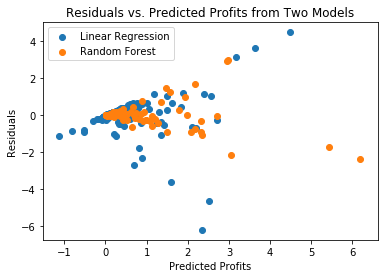

In [91]:
# Plot residual vs. predicted profits for linear regression
plt.scatter(linear_predict, linear_predict-ytest, label = 'Linear Regression')
plt.scatter(rf_regressor_predict, rf_regressor_predict-ytest, label = 'Random Forest')
plt.xlabel('Predicted Profits')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Profits from Two Models')
plt.legend(loc = 'best')